# Radio Bridge Injection and Analysis

This repository contains a Python-based workflow for simulating and analyzing **radio bridge emission**.  
The analysis demonstrates how to:

- Work with **FITS files** using `astropy`
- Inject visibilities into model images
- Create mosaics from restored images with varying spectral index
- Apply masks to isolate **radio bridge regions**
- Compute flux density ratios:
  $$
  R(\alpha) = \frac{S^{injected}_{400}}{S_{400}}
  $$

## Step 1: Load and Preprocess FITS Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
import pyregion
import FITS_tools

In [2]:
r_box=pyregion.open('box_mask.reg')
r_s=pyregion.open('halos_mask.reg')


In [3]:
#f=fits.open('final_subtracted_70_shifted-MFS-model-pb_copy.fits')[0]
f=fits.open('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits')[0]

# drops the size-1 axes
data=f.data.squeeze()
header=f.header
new_header = FITS_tools.strip_headers.flatten_header(header)
new_fh = fits.PrimaryHDU(data=data, header=new_header)
new_fh.writeto('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits', overwrite=True)


In [4]:
f=fits.open('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits')[0]
data=f.data

In [5]:
rb=r_box.as_imagecoord(f.header)
rs=r_s.as_imagecoord(f.header)

In [6]:
mask_box =rb.get_mask(shape=(1500, 1500))
mask_s=np.invert(rs.get_mask(shape=(1500,1500)))

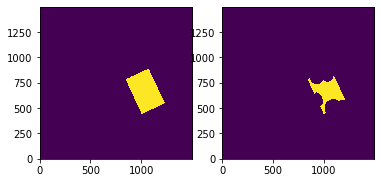

In [7]:
mask_tot=np.multiply(mask_box, mask_s)
mask_tot=mask_tot.astype('float32')
plt.subplot(121).imshow(mask_box, origin="lower", interpolation="nearest")
plt.subplot(122).imshow(mask_tot, origin="lower", interpolation="nearest")
plt.show()

In [8]:
hdu_mask=fits.open('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits')[0]

hdu_mask.data=mask_tot
hdu_mask.writeto('injection_models_shifted_2/mask.fits', overwrite=True)

In [9]:
hdu_model=fits.open('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits')[0]

header=hdu_model.header
hdu_model_data=np.multiply(hdu_model.data, mask_tot)

#header=fm.header

new_fh = fits.PrimaryHDU(data=hdu_model_data, header=header)
new_fh.writeto('injection_models_shifted_2/model_bridge.fits', overwrite=True)



## Step 2: Visibility Injection into Model Images


In [10]:
freqs=[316,348,385,416,449,481]

hdu_model=fits.open('injection_models_shifted_2/model_bridge.fits')[0]

data_mod=hdu_model.data

for freq in freqs:
    for alpha in np.arange(0,4.25,0.25):
        data_i=data_mod*(freq/60)**(-alpha)
        hdu_model.data=data_i
        hdu_model.writeto(f'/injection/injection_models_shifted_2/model_bridge_{freq}_alpha{alpha}.fits', overwrite=True)
        
        
        

In [11]:
#First pixel (top left) coordinates

w=wcs.WCS(f)
ra,dec=w.all_pix2world([1,1], [1500,1], 1)
xpix=ra[0]
ypix=dec[0]

xpix, ypix

(46.381504641085314, 14.694282347478827)

In [12]:
x_a399=np.zeros_like(data)
x_a401=np.zeros_like(data)

#pixelsize=6arcsec

#Distances x in arcmin from pointing center to pixel i,j:
for i in range(0,1500):
    for j in range(0,1500):
        x_a399[i,j]=60*np.sqrt((44.5000558-(xpix - 0.000833333*(2*i+1)))**2 + (13.1666828-(ypix - 0.000833333*(2*j+1)))**2)
        x_a401[i,j]=60*np.sqrt((44.679224-(xpix - 0.000833333*(2*i+1)))**2 + (13.4083497-(ypix - 0.000833333*(2*j+1)))**2)


In [4]:
#Beam uGMRT
def pb_ugmrt(x,a,b,c,d):
    return (1+(a/10**3)*x**2+(b/10**7)*x**4+(c/10**10)*x**6+(d/10**13)*x**8)

#band3 coefficients
a=-2.939
b=33.312
c=-16.659
d=3.066

In [14]:
from astropy.wcs import WCS

for freq in freqs:
    for alpha in np.arange(0,4.25,0.25):

        fm=fits.open(f'/injection/injection_models_shifted_2/model_bridge_{freq}_alpha{alpha}.fits')[0]
        datam=fm.data
    
        pb_cl1=pb_ugmrt(0.001*freq*np.flip(x_cl1,0), a,b,c,d)
        pb_cl2=pb_ugmrt(0.001*freq*np.flip(x_cl2,0), a,b,c,d)
                
        model_cl1=fits.open('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits')[0]
        model_cl1.data=np.multiply(pb_cl1,datam)
        
        
        model_cl1.writeto(f'/injection/injection_models_shifted_2/shifted_cl1/cl1_sub{freq}_alpha{alpha}-model.fits', overwrite=True)
    
        model_cl2=fits.open('injection_models_shifted_2/final_subtracted_70_shifted-MFS-model-pb.fits')[0]
        model_cl2.data=np.multiply(pb_cl2,datam)
        model_cl2.writeto(f'/injection/injection_models_shifted_2/shifted_cl2/cl2_sub{freq}_alpha{alpha}-model.fits', overwrite=True)
    

## Step 3: Mosaicking Restored Images with Different Spectral Index


First, drop the two degenerate axis in .fits file (freq and stokes) 

In [2]:
freqs=[316,348,385,416,449,481]

for alpha in np.arange(0,4.25,0.25):
    fh_cl1 = fits.open(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/cl1_inj/shift_cl1_2/cl1_injection_60mhz_alpha{alpha}-MFS-image.fits')
    fh_cl2 = fits.open(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/cl2_inj/shift_cl2_2/cl2_injection_60mhz_alpha{alpha}-MFS-image.fits')
    
    data_cl1 = fh_cl1[0].data.squeeze() # drops the size-1 axes
    data_cl2 = fh_cl2[0].data.squeeze() # drops the size-1 axes

    header1 = fh_cl1[0].header
    header2 = fh_cl2[0].header

    new_header1 = FITS_tools.strip_headers.flatten_header(header1)
    new_header2 = FITS_tools.strip_headers.flatten_header(header2)

    new_fh1 = fits.PrimaryHDU(data=data_cl1, header=new_header1)
    new_fh1.writeto(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/cl1_inj/shift_cl1_2/cl1_injection_60mhz_alpha{alpha}-MFS-image.fits', overwrite=True)
    
    new_fh2 = fits.PrimaryHDU(data=data_cl2, header=new_header2)
    new_fh2.writeto(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/cl2_inj/shift_cl2_2/cl2_injection_60mhz_alpha{alpha}-MFS-image.fits', overwrite=True)

Now set-up to mosaic inside for loop

In [5]:
for alpha in np.arange(0,4.25,0.25):
    #Open fits file (NAXIS=2), shape=437x437, pixelsize=16"
    fh_cl1 = fits.open(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/cl1_inj/shift_cl1_2/cl1_injection_60mhz_alpha{alpha}-MFS-image.fits')[0]
    fh_cl2 = fits.open(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/cl2_inj/shift_cl2_2/cl2_injection_60mhz_alpha{alpha}-MFS-image.fits')[0]
        
    data_cl1 = fh_cl1.data
    data_cl2 = fh_cl2.data
    
    header_cl1 = fh_cl1.header
    
    #Locate first N-W pixel
    w=wcs.WCS(fh_cl1)
    ra,dec=w.all_pix2world([1,1], [438,1], 1)
    xpix=ra[0]
    ypix=dec[0]
    
    #print(xpix,ypix)
    #Initialize two empty matrixs and fill them with distances from pointing center
    x_cl1=np.zeros_like(data_cl1)
    x_cl2=np.zeros_like(data_cl2)

    for i in range(0,438):
        for j in range(0,438):
            x_cl1[i,j]=60*np.sqrt((44.5000558-(xpix - 0.00222222*(2*i+1)))**2 + (13.1666828-(ypix - 0.00222222*(2*j+1)))**2)
            x_cl2[i,j]=60*np.sqrt((44.679224-(xpix - 0.00222222*(2*i+1)))**2 + (13.4083497-(ypix - 0.00222222*(2*j+1)))**2)

    #Compute uGMRT primary-beam correction
    w_cl1=pb_ugmrt(0.4*np.flip(x_cl1,0), a,b,c,d)
    w_cl2=pb_ugmrt(0.4*np.flip(x_cl2,0), a,b,c,d)
    
    data_mosaic=np.divide(np.multiply(data_cl1,w_cl1)+np.multiply(data_cl2,w_cl2),(w_cl1**2+w_cl2**2))
   
    mosaic = fits.PrimaryHDU(data=data_mosaic, header=header_cl1)
    mosaic.writeto(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/mosaic_inj/shifted_mosaic_2/mosaic_injection_60mhz_specindex{alpha}.fits', overwrite=True)

Now mask only bridge area and compute the ratio of flux density with injected visibilities and without R($\alpha$)=$\frac{S^{injected}_{400}}{S_{400}}$

In [25]:
f=fits.open('mosaic_inj/shifted_mosaic_2/mosaic_injection_60mhz_specindex0.0.fits')[0]
r_bridge=pyregion.open('box_mask_3.reg')
r_s=pyregion.open('halos_mask_3.reg')

rb=r_bridge.as_imagecoord(f.header)
rs=r_s.as_imagecoord(f.header)

mask_b1=rb.get_mask(shape=(438, 438))
mask_s=np.invert(rs.get_mask(shape=(438,438)))

mask_tot1=np.multiply(mask_b1,mask_s)
mask_tot1=mask_tot1.astype('float32')

hdu_mask=fits.open('mosaic_inj/shifted_mosaic_2/mosaic_injection_60mhz_specindex0.0.fits')[0]
hdu_mask.data=mask_tot1
hdu_mask.writeto('/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/injection_models_shifted_2/mask_R_438.fits', overwrite=True)

14.801495 0.21706316 0.0
8.567381 0.21706316 0.25
4.9452243 0.21706316 0.5
2.670508 0.21706316 0.75
1.2126746 0.21706316 1.0
0.69532293 0.21706316 1.25
0.5187326 0.21706316 1.5
0.34346208 0.21706316 1.75
0.22001739 0.21706316 2.0
0.23542278 0.21706316 2.25
0.18780215 0.21706316 2.5
0.118000396 0.21706316 2.75
0.1026204 0.21706316 3.0
0.06642433 0.21706316 3.25
0.06463401 0.21706316 3.5
0.04575209 0.21706316 3.75
0.044459224 0.21706316 4.0
[68.189804, 39.469532, 22.782421, 12.302907, 5.586736, 3.2033207, 2.3897772, 1.582314, 1.01361, 1.0845819, 0.8651959, 0.5436224, 0.47276747, 0.30601385, 0.2977659, 0.21077777, 0.2048216]
[0.4248428  0.6707498  0.8126911  0.8893419  0.9241489  0.9441066
 0.9589956  0.9688539  0.975169   0.98192626 0.98731667 0.9907036
 0.99364907 0.99555564 0.99741083 0.99872404 1.0000001 ]


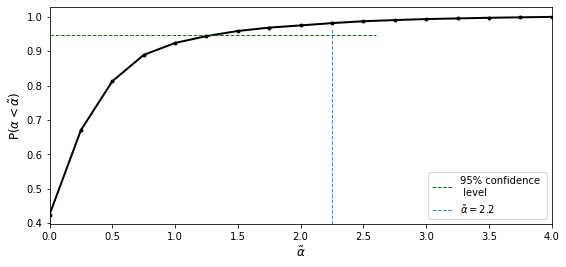

In [27]:
R=[]
for alpha in np.arange(0,4.25,0.25):
    inj_mosaic = fits.open(f'/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/mosaic_inj/shifted_mosaic_2/mosaic_injection_60mhz_specindex{alpha}.fits')[0]
    data_injmosaic=inj_mosaic.data
    data_in_mask_inj=np.multiply(data_injmosaic, mask_tot1)


    mosaic=fits.open('/Users/giadapignataro/Desktop/aplpy/bridge/mosaic.fits')[0]
    data_mosaic=mosaic.data
    data_in_mask=np.multiply(data_mosaic, mask_tot2)
    #R=np.sum(data_in_mask_inj)/(np.sum(data_in_mask))
    print(np.sum(data_in_mask_inj), np.sum(data_in_mask), alpha)
    R.append((np.sum(data_in_mask_inj))/(np.sum(data_in_mask)))
print(R)
    
A=np.sum(R)
#print(np.sum(R)/A)
cumulative=np.cumsum(R/A)
print(cumulative)
norm=cumulative.max()
#norm=np.sum(cumulative)*0.25
alpha=np.arange(0,4.25,0.25)


plt.rcParams["figure.figsize"] = (9,4)

plt.scatter(alpha, cumulative, s=35, marker='.', c='black', zorder=10)
plt.plot(alpha, cumulative, c='black', linewidth=2)

#plt.axhline(y=0.85, color='r', linestyle='-')
plt.axhline(y=0.948, xmin=0, xmax=0.65, color='g', linestyle='--', linewidth=1, label='95% confidence \n level')
plt.axvline(x=2.25, ymin=0, ymax=0.9, color='dodgerblue', linestyle='--', linewidth=1, label=r'$\tilde{\alpha}=2.2$')
plt.xlim(0,4)

plt.xlabel(r'$\tilde{\alpha}$', size='large')
plt.ylabel(r'P($\alpha<\tilde{\alpha}$)', size='large')
plt.legend(loc='lower right')
#plt.savefig('/Users/giadapignataro/Desktop/paper_bridge/cumulative_cl1cl2_4.png', facecolor='white')




In [38]:
inj_mosaic = fits.open('/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/mosaic_inj/mosaic_injection_60mhz_specindex3.75.fits', overwrite=True)[0]
data_injmosaic=inj_mosaic.data
r_box=pyregion.open('/Volumes/T7/Dottorato/cl1-cl2/LOFAR/injection/test.reg')
rb=r_box.as_imagecoord(inj_mosaic.header)
mask = rb.get_mask().to_image(inj_mosaic.header)
values_inside_region = data[mask > 0]
sum_inside_region = values_inside_region.sum()
print(f'Sum of pixel values inside the region: {sum_inside_region}')

RegionFilterException: the inut needs to be a numpy 2-d array or a tuple of two integers

## Step 4: Masking Bridge Region


In [43]:
import pyregion
from astropy.io import fits
from astropy.nddata import regions_to_mask
import numpy as np

# Read DS9 region file
region_file = '/Volumes/T7/Dottorato/A399-A401/LOFAR/injection/test.reg'
regions = pyregion.open(region_file)

# Read FITS file
fits_file = '/Volumes/T7/Dottorato/A399-A401/LOFAR/injection/mosaic_inj/mosaic_injection_60mhz_specindex3.75.fits'
hdu = fits.open(fits_file)[0]
data = hdu.data

# Create an empty mask
mask = regions_to_mask(regions, data.shape)

# Apply the mask to the data
values_inside_region = data[mask]

# Perform operations on values_inside_region
sum_inside_region = values_inside_region.sum()

print(f'Sum of pixel values inside the region: {sum_inside_region}')


ImportError: cannot import name 'regions_to_mask' from 'astropy.nddata' (/Users/giadapignataro/opt/anaconda3/lib/python3.9/site-packages/astropy/nddata/__init__.py)

Text(0, 0.5, 'Normalized R')

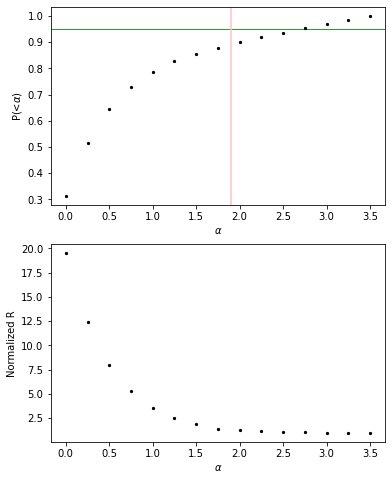

In [36]:
fig, axs = plt.subplots(2, figsize=(6,8))
axs[0].scatter(alpha, cumulative, s=20, marker='.', c='black', zorder=10)
axs[0].axhline(y=0.95, color='g', linestyle='-', linewidth=0.8)
axs[0].axvline(x=1.9, color='pink', linestyle='-')

axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel(r'P(<$\alpha$)')
axs[1].scatter(alpha, R, s=20, marker='.', c='black', zorder=10)
axs[1].set_xlabel(r'$\alpha$')
axs[1].set_ylabel(r'Normalized R')


In [13]:
hdu_mask=fits.open('/Users/giadapignataro/Desktop/aplpy/bridge/mosaic.fits')[0]
hdu_mask.data=data_in_mask_inj
hdu_mask.writeto('mask_R.fits', overwrite=True)

In [32]:
import numpy as np

alpha_min_values = np.arange(0, 1.25, 0.25)
alpha_max_values = np.arange(2.5, 4.25, 0.25)

alpha_lim = {
    0: [1.8, 1.85, 1.9, 2, 2.1, 2.2, 2.25],
    0.25: [1.8, 2, 2.1, 2.25, 2.3, 2.5, 2.75],
    0.5: [2, 2.25, 2.3, 2.5, 2.7, 2.75, 2.8],
    0.75: [2.2, 2.3, 2.5, 2.6, 2.75, 3, 3.1],
    1: [2.25, 2.5, 2.6, 2.75, 3, 3.2, 3.35]
}

matrix = np.zeros((len(alpha_max_values), len(alpha_min_values)))

# Fill the matrix with alpha_lim values
for i, alpha_max in enumerate(alpha_max_values):
    for j, alpha_min in enumerate(alpha_min_values):
        if alpha_min in alpha_lim and alpha_max in alpha_lim[alpha_min]:
            matrix[i, j] = alpha_lim[alpha_min][alpha_lim[alpha_min].index(alpha_max)]

print(matrix)

[[0.   2.5  2.5  2.5  2.5 ]
 [0.   2.75 2.75 2.75 2.75]
 [0.   0.   0.   3.   3.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]]


In [4]:
import numpy as np

N = 5  # Number of columns
M = 7  # Number of rows

column_values = {
    0: [1.8, 1.85, 1.9, 2.1, 2.2, 2.25, 2.3],
    1: [1.87, 2, 2.1, 2.25, 2.35, 2.5, 2.6],
    2: [2, 2.2, 2.3, 2.5, 2.7, 2.75, 2.8],
    3: [2.1, 2.3, 2.5, 2.6, 2.8, 3, 3.15],
    4: [2.2, 2.45, 2.6, 2.75, 3, 3.2, 3.35]
}

diff_values = {
    0: [0, 0.05, 0.05, 0.2, 0.1, 0.05, 0.05],
    1: [0, 0.13, 0.1, 0.15, 0.1, 0.15, 0.1],
    2: [0, 0.2, 0.1, 0.2, 0.2, 0.05, 0.05],
    3: [0, 0.2, 0.2, 0.1, 0.2, 0.2, 0.15],
    4: [0, 0.25, 0.15, 0.15, 0.25, 0.2, 0.15]
}

matrix = np.zeros((M, N))
diff_matrix = np.zeros((M, N))

for col in range(N):
    matrix[:, col] = column_values[col]
    diff_matrix[:, col] = diff_values[col]


print(matrix)
print(diff_matrix)


[[1.8  1.87 2.   2.1  2.2 ]
 [1.85 2.   2.2  2.3  2.45]
 [1.9  2.1  2.3  2.5  2.6 ]
 [2.1  2.25 2.5  2.6  2.75]
 [2.2  2.35 2.7  2.8  3.  ]
 [2.25 2.5  2.75 3.   3.2 ]
 [2.3  2.6  2.8  3.15 3.35]]
[[0.   0.   0.   0.   0.  ]
 [0.05 0.13 0.2  0.2  0.25]
 [0.05 0.1  0.1  0.2  0.15]
 [0.2  0.15 0.2  0.1  0.15]
 [0.1  0.1  0.2  0.2  0.25]
 [0.05 0.15 0.05 0.2  0.2 ]
 [0.05 0.1  0.05 0.15 0.15]]


## Step 5: Flux Density Ratio Calculation


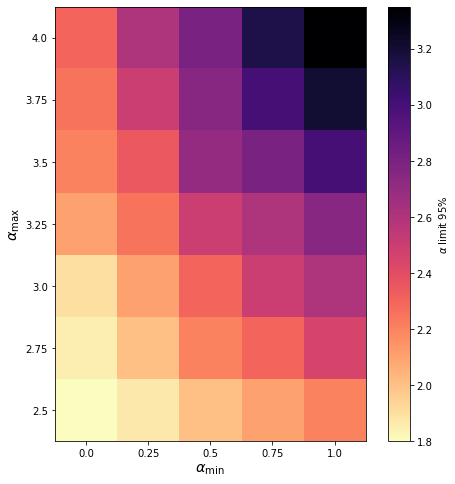

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(matrix, cmap='magma_r', origin='lower')

cbar = ax.figure.colorbar(im, ax=ax, label=r'$\alpha$ limit 95%')

# Set the tick labels
alpha_min_ticks = np.arange(N)
alpha_max_ticks = np.arange(M)

alpha_min_values = [0.0, 0.25, 0.5, 0.75, 1.0]
alpha_max_values = [2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

ax.set_xticks(alpha_min_ticks)
ax.set_yticks(alpha_max_ticks)
ax.set_xticklabels(alpha_min_values)
ax.set_yticklabels(alpha_max_values)

# Add labels to the x and y axes
ax.set_xlabel(r'$\alpha_{\min}$', size='x-large')
ax.set_ylabel(r'$\alpha_{\max}$', size='x-large')

plt.savefig('/Users/giadapignataro/Desktop/paper_bridge/alpharanges.png', facecolor='white')

plt.show()


In [43]:
A_0=[18436, 18706, 18977, 19186, 19336, 19483, 19610, 19747, 19858]
A_025=[13329, 13600, 13870, 14079, 14229, 14377, 14503, 14641, 14756]
A_05=[9359, 9630, 9900, 10109, 10259, 10406, 10533, 10670, 10781]
A_075=[6208, 6479, 6749, 6958, 7108, 7256, 7382, 7520, 7631]
A_1=[3782, 4053, 4323, 4532, 4682, 4829, 4956, 5093, 5204]

A=[A_0, A_025, A_05, A_075, A_1]


In [44]:
#percentage_diff = [0]  # Initialize the first percentage difference as 0
import numpy as np
for a in A:
    percentage_diff = [0]
    for i in range(1, len(a)):
        diff = a[i] - a[i-1]
        percentage = (diff / a[i-1]) * 100
        percentage_diff.append(np.round(percentage,2))

    print(percentage_diff)

[0, 1.46, 1.45, 1.1, 0.78, 0.76, 0.65, 0.7, 0.56]
[0, 2.03, 1.99, 1.51, 1.07, 1.04, 0.88, 0.95, 0.79]
[0, 2.9, 2.8, 2.11, 1.48, 1.43, 1.22, 1.3, 1.04]
[0, 4.37, 4.17, 3.1, 2.16, 2.08, 1.74, 1.87, 1.48]
[0, 7.17, 6.66, 4.83, 3.31, 3.14, 2.63, 2.76, 2.18]


In [65]:
a_0=[1.75, 1.85, 1.9, 2, 2.1, 2.2, 2.25]
a_025=[1.87, 2, 2.1, 2.25, 2.35, 2.5, 2.6]
a_05=[2, 2.2, 2.3, 2.5, 2.7, 2.75, 2.8]
a_075=[2.1, 2.3, 2.5, 2.65, 2.75, 3, 3.1]
a_1=[2.2, 2.45, 2.6, 2.75, 3, 3.2, 3.35]

al=[a_0, a_025, a_05, a_075, a_1]

In [66]:
#percentage_diff = [0]  # Initialize the first percentage difference as 0
import numpy as np
for a in al:
    percentage_diff = [0]
    for i in range(1, len(a)):
        diff = a[i] - a[i-1]
        percentage = (diff / a[i-1]) * 100
        percentage_diff.append(np.round(percentage,2))

    print(percentage_diff)

[0, 5.71, 2.7, 5.26, 5.0, 4.76, 2.27]
[0, 6.95, 5.0, 7.14, 4.44, 6.38, 4.0]
[0, 10.0, 4.55, 8.7, 8.0, 1.85, 1.82]
[0, 9.52, 8.7, 6.0, 3.77, 9.09, 3.33]
[0, 11.36, 6.12, 5.77, 9.09, 6.67, 4.69]


In [4]:
import numpy as np

N = 5  # Number of columns
M =  8 # Number of rows

column_values = {
    0: [1.46, 1.45, 1.1, 0.78, 0.76, 0.65, 0.64, 0.56],
    1: [2.03, 1.99, 1.51, 1.07, 1.04, 0.88, 0.87, 0.79],
    2: [2.9, 2.8, 2.11, 1.48, 1.43, 1.22, 1.2, 1.04],
    3: [4.37, 4.17, 3.1, 2.16, 2.08, 1.74, 1.72, 1.48],
    4: [7.17, 6.66, 4.83, 3.31, 3.14, 2.63, 2.6, 2.18]
}

matrix = np.zeros((M, N))

for col in range(N):
    matrix[:, col] = column_values[col]

print(matrix)

[[1.46 2.03 2.9  4.37 7.17]
 [1.45 1.99 2.8  4.17 6.66]
 [1.1  1.51 2.11 3.1  4.83]
 [0.78 1.07 1.48 2.16 3.31]
 [0.76 1.04 1.43 2.08 3.14]
 [0.65 0.88 1.22 1.74 2.63]
 [0.64 0.87 1.2  1.72 2.6 ]
 [0.56 0.79 1.04 1.48 2.18]]


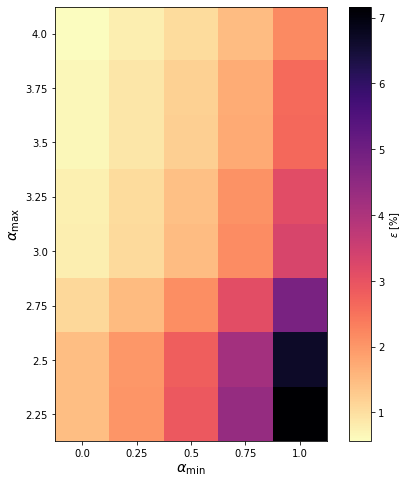

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(matrix, cmap='magma_r', origin='lower')

cbar = ax.figure.colorbar(im, ax=ax, label=r'$\epsilon$ [%]')

# Set the tick labels
alpha_min_ticks = np.arange(N)
alpha_max_ticks = np.arange(M)

alpha_min_values = [0.0, 0.25, 0.5, 0.75, 1.0]
alpha_max_values = [2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

ax.set_xticks(alpha_min_ticks)
ax.set_yticks(alpha_max_ticks)
ax.set_xticklabels(alpha_min_values)
ax.set_yticklabels(alpha_max_values)

# Add labels to the x and y axes
ax.set_xlabel(r'$\alpha_{\min}$', size='x-large')
ax.set_ylabel(r'$\alpha_{\max}$', size='x-large')

plt.savefig('/Users/giadapignataro/Desktop/paper_bridge/aconvergence.png', facecolor='white')

plt.show()


## Conclusion

In this notebook, we simulated the **injection of visibilities** into radio observations  
to study the properties of a **radio bridge structure**.  

Key outcomes:
- Successfully handled and manipulated FITS data
- Generated mosaicked images with varying spectral indices
- Applied masks to isolate and analyze bridge emission
- Computed flux density ratios to quantify the effect of injected visibilities

This project demonstrates practical skills in **scientific Python programming**, including data manipulation, astrophysical modeling, and reproducible workflows.  
